In [21]:
import pandas as pd
import numpy as np
import re
from zipfile import ZipFile, Path
import json

archive_path = '/home/bobiyu/Documents/UNI/ПТС/InputData.zip'

In [4]:
allowed_file_extentions = ('.xls','.xlsx', '.ods', '.odf' ,'.odt', '.csv')

#### Case: Zip file uploaded for course analysis

In [5]:
results_df = []
logs_df = []

with ZipFile(archive_path) as input_archive:
    %time
    for item in input_archive.namelist():
        if item.endswith(allowed_file_extentions):
            with input_archive.open(item) as data_file:
                if data_file.name.endswith(allowed_file_extentions[-1]):                    
                    df = pd.read_csv(data_file)
                else:
                    df = pd.read_excel(data_file)
                    
                if 'ID' and 'Result' in df.columns:
                    results_df.append(df)
                    print('Result file found! Appending DF to list.')
                elif 'Event' and 'Component' in df.columns:
                    df['User ID'] = df['Description'].apply(lambda x: np.int32(re.sub(r"[\D]+",' ', x).strip().split()[0]))
                    logs_df.append(df)
                    print('Log file found! Appending DF to list.')
                else:
                    print('Nothing found!')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs
Result file found! Appending DF to list.
Result file found! Appending DF to list.
Log file found! Appending DF to list.


In [6]:
%time
student_results = pd.concat(results_df).sort_values(by='ID', ascending=True)
del results_df

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


In [7]:
%time
system_logs = pd.concat(logs_df)
del logs_df

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.48 µs


### честотно разпределение

In [35]:
%time
res_abs_freq = student_results['Result'].value_counts()

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 14.8 µs


In [45]:
res_total = res_abs_freq.sum()
print(res_total)

136


In [46]:
#calculate relative freq
res_abs_freq.apply(lambda r: np.round(r / res_total *100, 2))

6.0    50.74
5.0    19.12
4.0    15.44
2.0     9.56
3.0     4.41
3.5     0.74
Name: Result, dtype: float64

In [57]:
%time
keys = res_abs_freq.keys().sort_values()

ret = []

for k in keys:
    d = {}
    d['Result'] = k
    d['Abs freq'] = res_abs_freq[k]
    d['Rel freq'] = np.round(res_abs_freq[k] / res_total * 100, 2)
    ret.append(d)


CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 17.9 µs


In [58]:
ret

[{'Result': 2.0, 'Abs freq': 13, 'Rel freq': 9.56},
 {'Result': 3.0, 'Abs freq': 6, 'Rel freq': 4.41},
 {'Result': 3.5, 'Abs freq': 1, 'Rel freq': 0.74},
 {'Result': 4.0, 'Abs freq': 21, 'Rel freq': 15.44},
 {'Result': 5.0, 'Abs freq': 26, 'Rel freq': 19.12},
 {'Result': 6.0, 'Abs freq': 69, 'Rel freq': 50.74}]

In [59]:
pd.DataFrame.from_dict(ret)

,Result,Abs freq,Rel freq
0,2.0,13,9.56
1,3.0,6,4.41
2,3.5,1,0.74
3,4.0,21,15.44
4,5.0,26,19.12
5,6.0,69,50.74


### мерки на централната тенденция

In [61]:
upr_num = '2'
event_context = f'Assignment: Качване на Упр. {upr_num}'
event_name = 'Submission created.'

In [104]:
%time
df = system_logs
filtered_data = df[df['Event context'].str.contains(event_context) & (df['Event name'] == event_name)]['Description']

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [64]:
%time
uploded_files = np.empty_like(filtered_data, dtype=int)
# uploded_files = []

for index, item in enumerate(filtered_data):
    val = re.sub(r"[\D]+",' ', item).strip()
    uploded_files[index] = np.fromstring(val, dtype=np.int32, sep=' ')[1]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [66]:
uploded_files.sort()

In [67]:
uploded_files

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [69]:
uploded_files_stats = {}

In [74]:
from statistics import mode

#mode
uploded_files_stats['mode'] = mode(uploded_files)

#average
uploded_files_stats['mean'] = np.round(np.mean(uploded_files), 3)

#meadian
uploded_files_stats['median'] = np.median(uploded_files)

In [75]:
uploded_files_stats

{'mode': 1, 'mean': 1.059, 'median': 1.0}

### мерки на разсейване

In [86]:
spread_measurements = {}

In [87]:
#размах
spread_measurements['spread'] = uploded_files[-1] - uploded_files[0]

#dispersion
spread_measurements['variance'] = np.round(np.var(uploded_files), 4)

#STDEV
spread_measurements['std'] = np.round(np.std(uploded_files), 4)

In [88]:
print(spread_measurements)

{'spread': 1, 'variance': 0.0554, 'std': 0.2353}


### корелационен анализ

In [8]:
corr_df = student_results.copy()

In [9]:
df = system_logs
corr_df['View Count'] = corr_df['ID'].apply(lambda uid: df[df['Event name'].str.contains('Course viewed') & (df['User ID']==uid)]['User ID'].count())

In [10]:
corr_df.head(6)

,ID,Result,View Count
8,6532,6.0,66
4,7448,5.0,2
3,7907,6.0,42
5,7909,4.0,28
6,7910,5.0,58
7,7911,4.0,31


In [11]:
corr = np.round(corr_df[['Result', 'View Count']].corr()['View Count']['Result'], 5)

In [12]:
if corr == 0:
    print('липсва зависимост')
elif 0 > corr <= 0.3:
    print(corr, ',зависимостта е слаба')
elif 0.3 > corr <= 0.5:
    print(corr, ',умерена зависимост')
elif 0.5 > corr <= 0.7:
    print(corr, ',значителна зависимост')
elif 0.7 > corr <= 0.9:
    print(corr, ',силна зависимост')
elif 0.9 > corr < 1:
    print(corr, ',много силна зависимост')
elif corr == 1:
    print(corr, ',зависимостта е функционална')

0.3304 значителна зависимост


In [20]:
dt = {'correlation': 0.3304, 'dependency': 'значителна зависимост'}

In [22]:
json.dumps(dt)

'{"correlation": 0.3304, "dependency": "\\u0437\\u043d\\u0430\\u0447\\u0438\\u0442\\u0435\\u043b\\u043d\\u0430 \\u0437\\u0430\\u0432\\u0438\\u0441\\u0438\\u043c\\u043e\\u0441\\u0442"}'

### честотното разпределение на данните от Вариант B

In [13]:
total_vc = corr_df['View Count'].sum()

In [14]:
corr_df['Result rel freq'] = corr_df['View Count'].apply(lambda vc: np.round(vc / total_vc *100, 2))

In [16]:
corr_df.head(8)

,ID,Result,View Count,Result rel freq
8,6532,6.0,66,0.73
4,7448,5.0,2,0.02
3,7907,6.0,42,0.47
5,7909,4.0,28,0.31
6,7910,5.0,58,0.65
7,7911,4.0,31,0.34
9,7912,4.0,17,0.19
13,7913,6.0,105,1.17


In [19]:
corr_df.shape

(136, 4)

In [24]:
pt = ''
corr_df.to_json(orient='records')

'[{"ID":6532,"Result":6.0,"View Count":66,"Result rel freq":0.73},{"ID":7448,"Result":5.0,"View Count":2,"Result rel freq":0.02},{"ID":7907,"Result":6.0,"View Count":42,"Result rel freq":0.47},{"ID":7909,"Result":4.0,"View Count":28,"Result rel freq":0.31},{"ID":7910,"Result":5.0,"View Count":58,"Result rel freq":0.65},{"ID":7911,"Result":4.0,"View Count":31,"Result rel freq":0.34},{"ID":7912,"Result":4.0,"View Count":17,"Result rel freq":0.19},{"ID":7913,"Result":6.0,"View Count":105,"Result rel freq":1.17},{"ID":7914,"Result":4.0,"View Count":5,"Result rel freq":0.06},{"ID":7915,"Result":6.0,"View Count":106,"Result rel freq":1.18},{"ID":7916,"Result":5.0,"View Count":33,"Result rel freq":0.37},{"ID":7917,"Result":4.0,"View Count":61,"Result rel freq":0.68},{"ID":7918,"Result":5.0,"View Count":7,"Result rel freq":0.08},{"ID":7919,"Result":6.0,"View Count":49,"Result rel freq":0.55},{"ID":7921,"Result":4.0,"View Count":25,"Result rel freq":0.28},{"ID":7922,"Result":3.5,"View Count":12

<AxesSubplot:xlabel='Result', ylabel='View Count'>

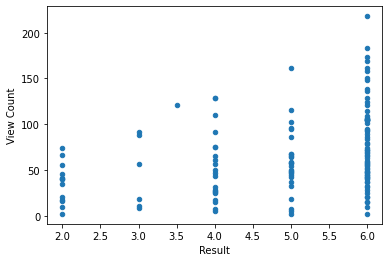

In [27]:
corr_df.plot(x ='Result', y='View Count', kind = 'scatter')